In [4]:
import sys
sys.path.insert(0, '../casadi_f16')
import f16
import control
import numpy as np
import matplotlib.pyplot as plt
from analysis import loop_analysis

In [5]:
!pip install casadi

# Pitch-Rate CAS Design

* Example 4.5-1
* pg. 310

In [6]:
p = f16.Parameters()
x0, u0 = f16.trim(s0=[0, 0, 0, 0, 0, 0], x=f16.State(
    VT=550), p=p,
    phi_dot=0, theta_dot=0, psi_dot=0.0, gam=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

               t_proc [s]   t_wall [s]    n_eval
           S      0.00613      0.00608         1
       nlp_f      0.00026      0.00026         8
  nlp_grad_f     0.000657     0.000659         9
  nlp_hess_l      0.00157      0.00158         7


In [7]:
f_control = lambda t, x: f16.Control(thtl=u0.thtl, ail_deg=u0.ail_deg, elv_deg=u0.elv_deg + 1*np.sin(2*np.pi*2*t), rdr_deg=u0.rdr_deg)
f_control(0, x0)

Control(thtl=DM(0.166459), ail_deg=DM(0), elv_deg=DM(-0.807378), rdr_deg=DM(0))

Text(0.5, 1.0, 'angle of attack')

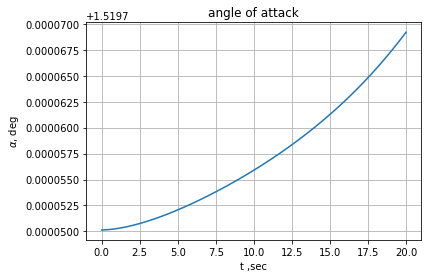

In [8]:
res = f16.simulate(x0, u0, p, 0, 20, 0.01)
plt.plot(res['t'], np.rad2deg(res['x'][:, f16.State().name_to_index('alpha')]))
plt.xlabel('t ,sec')
plt.ylabel(r'$\alpha$, deg')
plt.grid()
plt.title('angle of attack')

Text(0.5, 1.0, 'trajectory')

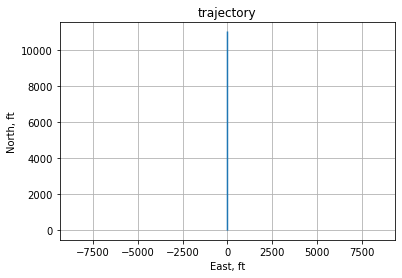

In [9]:
res = f16.simulate(x0, u0, p, 0, 20, 0.01)

plt.plot(res['x'][:, f16.State().name_to_index('p_E')], res['x'][:, f16.State().name_to_index('p_N')])
plt.axis('equal');
plt.xlabel('East, ft')
plt.ylabel('North, ft')
plt.grid()
plt.title('trajectory')

In [15]:
ss = f16.linearize(x0, u0, p)
s = control.tf([1, 0], [0, 1])
G = 180/np.pi*ss.sub_system(x=['alpha', 'Q'],
                  u=['elv_deg'], y=['alpha', 'Q']).to_control()

# represents elevator motor
sysa = -20.2/(s + 20.2) # actuator and sign change

sys1 = G*sysa # output is on left, input on right, so plant*actuator
sysf = control.ss(-10, [10, 0], [[1], [0]], [[0, 0], [0, 1]])  # aoa low-pass filter
sys2 = sysf*sys1

# closed inner loop
Kalpha = 0.2 # inner aoa gain
sys3 = control.ss(sys2.A - sys2.B*[Kalpha, 0]*sys2.C, sys2.B, sys2.C, sys2.D)

sysi = (s+3)/s # PI controller
sys4 = sys3[1, 0]*sysi

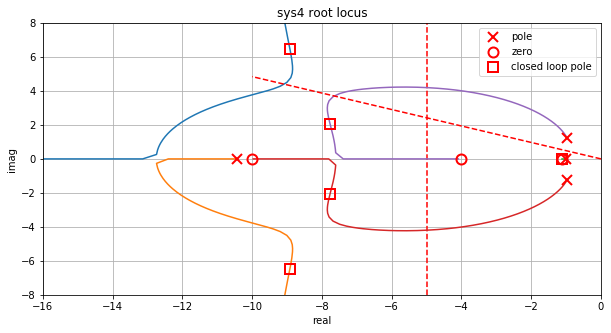

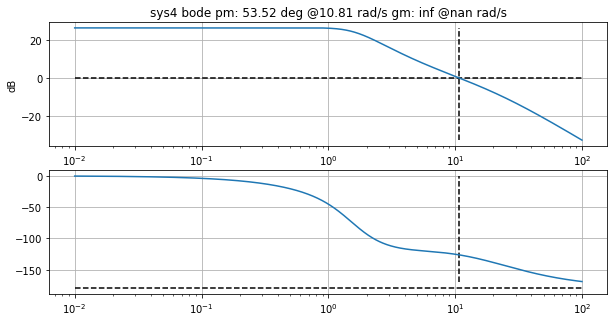

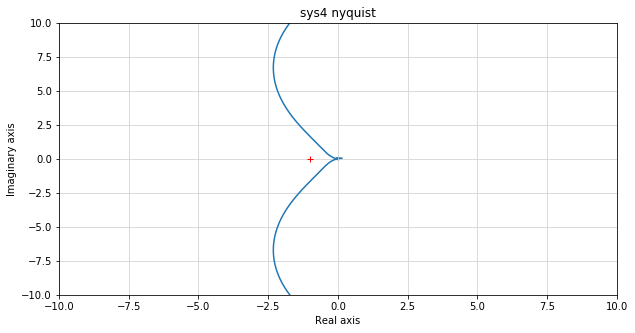

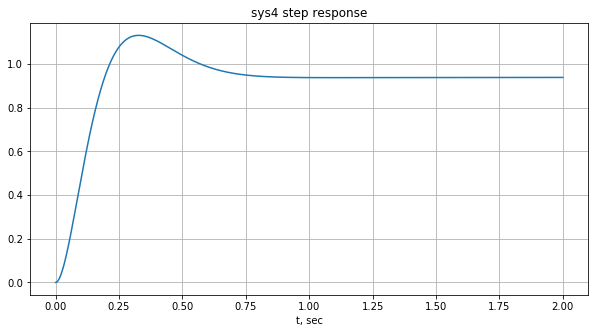

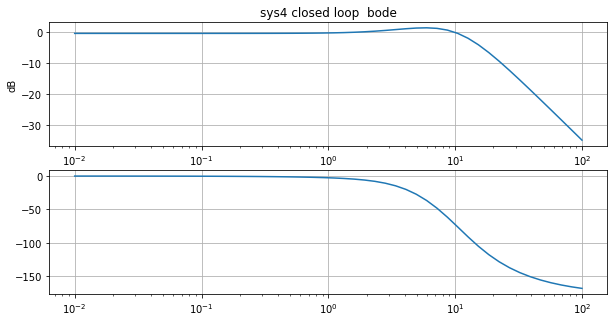

In [16]:
loop_analysis('sys4', (s+3)/s*sys3[1, 0], zeta=0.9, wd=5, k=0.75, t_vect=np.linspace(0, 2, 1000), k_vect=np.logspace(-2, 1, 1000),
              omega_vect=np.logspace(-2, 2, 1000))